In [1]:
# Part 1: Setup and Imports
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Part 2: Load CIFAR-10 Dataset

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Data transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

# Split training into train and validation
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_data, val_data = random_split(trainset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(testset)}")


100%|██████████| 170M/170M [00:03<00:00, 44.1MB/s]


Training samples: 40000
Validation samples: 10000
Test samples: 10000


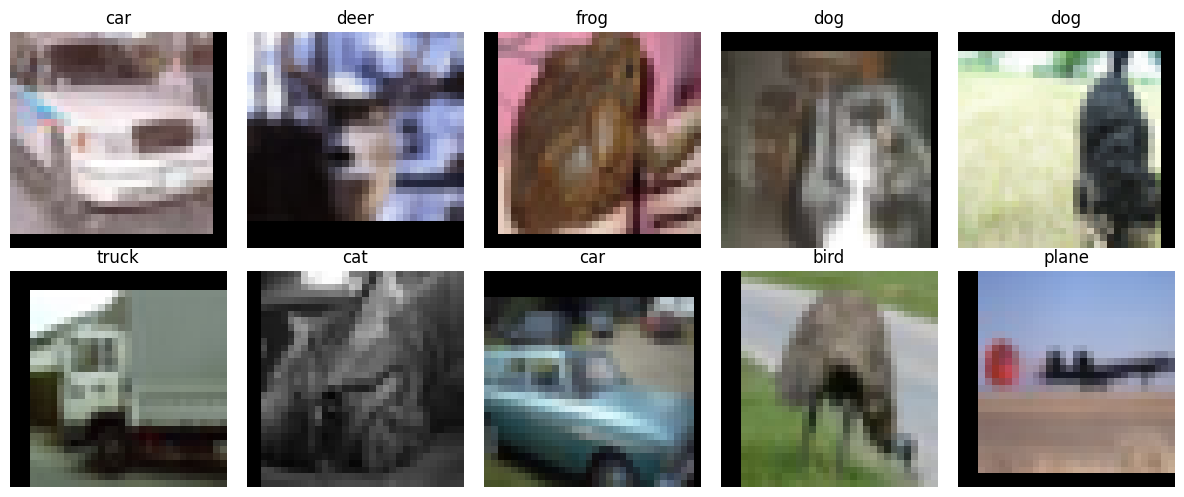

In [4]:
# Part 3: Visualize Some Images
# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.transpose(images[idx].numpy() / 2 + 0.5, (1, 2, 0)))
    ax.set_title(classes[labels[idx]])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# Part 4: Load Pre-trained ResNet18
# Load pre-trained ResNet18
model = models.resnet18(pretrained=True)

# EXPERIMENT 1: UNFROZEN (Train all layers)
# Just run like normal

# EXPERIMENT 2: FROZEN (Feature extraction only)
# Uncomment these lines to freeze:
# for param in model.parameters():
#     param.requires_grad = False

# Replace the final layer for CIFAR-10 (10 classes)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

# Move model to GPU
model = model.to(device)

print(model.fc)  # Check the final layer

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]


Linear(in_features=512, out_features=10, bias=True)


In [6]:
# Part 5: Training Setup
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

# For tracking metrics
train_losses = []
val_losses = []
train_accuracies =[]
val_accuracies = []


In [7]:
# Part 6: Training and Validation Functions
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, label in tqdm(loader, desc = "Training"):
        images, label = images.to(device), label.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, label)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += label.size(0)
        correct += predicted.eq(label).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, label in tqdm(loader, desc = "Validation"):
            images, label = images.to(device), label.to(device)

            outputs = model(images)
            loss = criterion(outputs, label)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc


In [8]:
# Part 7: Train the model
# Train for many epochs to see overfitting
num_epochs = 50 # Try 50 epochs to see overfitting clearly

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')



Epoch 1/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.61it/s]


Train Loss: 1.3814 | Train Acc: 51.08%
Val Loss: 1.0560 | Val Acc: 62.31%

Epoch 2/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.86it/s]


Train Loss: 0.9424 | Train Acc: 66.88%
Val Loss: 0.8858 | Val Acc: 68.54%

Epoch 3/50


Validation: 100%|██████████| 79/79 [00:04<00:00, 19.19it/s]


Train Loss: 0.8168 | Train Acc: 71.68%
Val Loss: 0.7892 | Val Acc: 72.58%

Epoch 4/50


Validation: 100%|██████████| 79/79 [00:04<00:00, 18.77it/s]


Train Loss: 0.7371 | Train Acc: 74.23%
Val Loss: 0.7371 | Val Acc: 74.25%

Epoch 5/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.41it/s]


Train Loss: 0.6790 | Train Acc: 76.32%
Val Loss: 0.7000 | Val Acc: 75.63%

Epoch 6/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 24.25it/s]


Train Loss: 0.6327 | Train Acc: 77.64%
Val Loss: 0.6765 | Val Acc: 76.58%

Epoch 7/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.73it/s]


Train Loss: 0.5967 | Train Acc: 78.98%
Val Loss: 0.6575 | Val Acc: 77.16%

Epoch 8/50


Validation: 100%|██████████| 79/79 [00:04<00:00, 18.55it/s]


Train Loss: 0.5612 | Train Acc: 80.18%
Val Loss: 0.6425 | Val Acc: 77.75%

Epoch 9/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.79it/s]


Train Loss: 0.5376 | Train Acc: 81.17%
Val Loss: 0.6186 | Val Acc: 78.44%

Epoch 10/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.47it/s]


Train Loss: 0.5122 | Train Acc: 81.83%
Val Loss: 0.6212 | Val Acc: 78.94%

Epoch 11/50


Validation: 100%|██████████| 79/79 [00:04<00:00, 18.84it/s]


Train Loss: 0.4851 | Train Acc: 82.90%
Val Loss: 0.6160 | Val Acc: 78.90%

Epoch 12/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 22.39it/s]


Train Loss: 0.4671 | Train Acc: 83.48%
Val Loss: 0.5992 | Val Acc: 79.00%

Epoch 13/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.65it/s]


Train Loss: 0.4482 | Train Acc: 84.11%
Val Loss: 0.5931 | Val Acc: 79.98%

Epoch 14/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.40it/s]


Train Loss: 0.4268 | Train Acc: 85.05%
Val Loss: 0.5985 | Val Acc: 79.51%

Epoch 15/50


Validation: 100%|██████████| 79/79 [00:04<00:00, 18.14it/s]


Train Loss: 0.4125 | Train Acc: 85.34%
Val Loss: 0.5792 | Val Acc: 80.88%

Epoch 16/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.00it/s]


Train Loss: 0.3934 | Train Acc: 86.08%
Val Loss: 0.5904 | Val Acc: 80.30%

Epoch 17/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.45it/s]


Train Loss: 0.3841 | Train Acc: 86.34%
Val Loss: 0.5873 | Val Acc: 80.28%

Epoch 18/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 21.01it/s]


Train Loss: 0.3637 | Train Acc: 87.10%
Val Loss: 0.5985 | Val Acc: 80.36%

Epoch 19/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 19.83it/s]


Train Loss: 0.3506 | Train Acc: 87.44%
Val Loss: 0.5899 | Val Acc: 80.98%

Epoch 20/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 24.27it/s]


Train Loss: 0.3408 | Train Acc: 88.00%
Val Loss: 0.5750 | Val Acc: 81.18%

Epoch 21/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.80it/s]


Train Loss: 0.3222 | Train Acc: 88.56%
Val Loss: 0.5984 | Val Acc: 80.66%

Epoch 22/50


Validation: 100%|██████████| 79/79 [00:04<00:00, 18.03it/s]


Train Loss: 0.3075 | Train Acc: 89.05%
Val Loss: 0.6010 | Val Acc: 80.66%

Epoch 23/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.12it/s]


Train Loss: 0.3032 | Train Acc: 89.21%
Val Loss: 0.5733 | Val Acc: 81.21%

Epoch 24/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.53it/s]


Train Loss: 0.2882 | Train Acc: 89.65%
Val Loss: 0.6053 | Val Acc: 80.75%

Epoch 25/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.44it/s]


Train Loss: 0.2750 | Train Acc: 90.22%
Val Loss: 0.5949 | Val Acc: 81.58%

Epoch 26/50


Validation: 100%|██████████| 79/79 [00:04<00:00, 18.23it/s]


Train Loss: 0.2681 | Train Acc: 90.44%
Val Loss: 0.6084 | Val Acc: 81.31%

Epoch 27/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.41it/s]


Train Loss: 0.2571 | Train Acc: 90.74%
Val Loss: 0.6090 | Val Acc: 81.27%

Epoch 28/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.63it/s]


Train Loss: 0.2468 | Train Acc: 91.11%
Val Loss: 0.6209 | Val Acc: 81.25%

Epoch 29/50


Validation: 100%|██████████| 79/79 [00:04<00:00, 19.38it/s]


Train Loss: 0.2382 | Train Acc: 91.38%
Val Loss: 0.6122 | Val Acc: 81.54%

Epoch 30/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.99it/s]


Train Loss: 0.2298 | Train Acc: 91.61%
Val Loss: 0.6109 | Val Acc: 81.46%

Epoch 31/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.88it/s]


Train Loss: 0.2149 | Train Acc: 92.43%
Val Loss: 0.6237 | Val Acc: 81.52%

Epoch 32/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 22.40it/s]


Train Loss: 0.2165 | Train Acc: 92.39%
Val Loss: 0.6293 | Val Acc: 81.97%

Epoch 33/50


Validation: 100%|██████████| 79/79 [00:04<00:00, 18.13it/s]


Train Loss: 0.2046 | Train Acc: 92.76%
Val Loss: 0.6463 | Val Acc: 81.22%

Epoch 34/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.15it/s]


Train Loss: 0.1979 | Train Acc: 92.88%
Val Loss: 0.6458 | Val Acc: 81.14%

Epoch 35/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.76it/s]


Train Loss: 0.1953 | Train Acc: 93.07%
Val Loss: 0.6435 | Val Acc: 81.56%

Epoch 36/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 22.77it/s]


Train Loss: 0.1837 | Train Acc: 93.41%
Val Loss: 0.6460 | Val Acc: 81.51%

Epoch 37/50


Validation: 100%|██████████| 79/79 [00:04<00:00, 17.84it/s]


Train Loss: 0.1736 | Train Acc: 93.84%
Val Loss: 0.6439 | Val Acc: 81.48%

Epoch 38/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.63it/s]


Train Loss: 0.1690 | Train Acc: 94.08%
Val Loss: 0.6614 | Val Acc: 81.59%

Epoch 39/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.20it/s]


Train Loss: 0.1684 | Train Acc: 94.03%
Val Loss: 0.6627 | Val Acc: 81.36%

Epoch 40/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.77it/s]


Train Loss: 0.1572 | Train Acc: 94.41%
Val Loss: 0.6874 | Val Acc: 81.46%

Epoch 41/50


Validation: 100%|██████████| 79/79 [00:04<00:00, 19.01it/s]


Train Loss: 0.1529 | Train Acc: 94.53%
Val Loss: 0.6737 | Val Acc: 81.69%

Epoch 42/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 22.87it/s]


Train Loss: 0.1450 | Train Acc: 94.79%
Val Loss: 0.6800 | Val Acc: 81.89%

Epoch 43/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.62it/s]


Train Loss: 0.1507 | Train Acc: 94.73%
Val Loss: 0.6823 | Val Acc: 81.51%

Epoch 44/50


Validation: 100%|██████████| 79/79 [00:04<00:00, 18.40it/s]


Train Loss: 0.1402 | Train Acc: 95.00%
Val Loss: 0.6799 | Val Acc: 82.03%

Epoch 45/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 20.39it/s]


Train Loss: 0.1402 | Train Acc: 95.03%
Val Loss: 0.7029 | Val Acc: 81.44%

Epoch 46/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 22.94it/s]


Train Loss: 0.1318 | Train Acc: 95.33%
Val Loss: 0.6967 | Val Acc: 81.62%

Epoch 47/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.37it/s]


Train Loss: 0.1283 | Train Acc: 95.48%
Val Loss: 0.7263 | Val Acc: 81.86%

Epoch 48/50


Validation: 100%|██████████| 79/79 [00:04<00:00, 17.70it/s]


Train Loss: 0.1247 | Train Acc: 95.65%
Val Loss: 0.6886 | Val Acc: 82.11%

Epoch 49/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 22.68it/s]


Train Loss: 0.1192 | Train Acc: 95.78%
Val Loss: 0.7172 | Val Acc: 81.86%

Epoch 50/50


Validation: 100%|██████████| 79/79 [00:03<00:00, 23.48it/s]

Train Loss: 0.1100 | Train Acc: 96.08%
Val Loss: 0.7110 | Val Acc: 81.92%


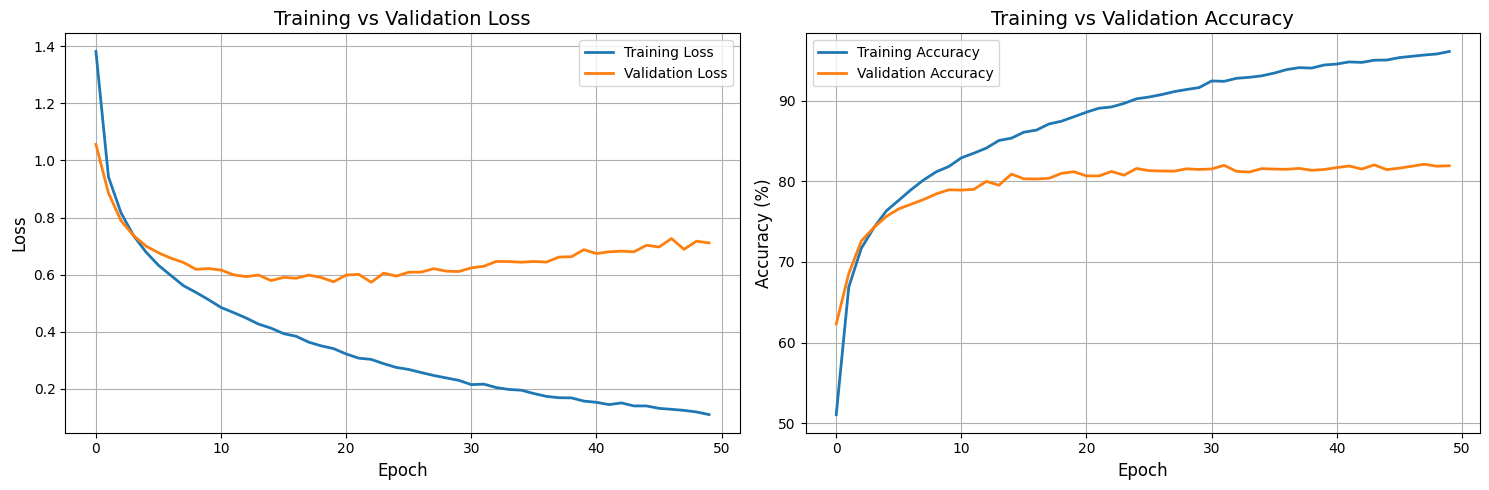


Best validation loss at epoch: 23
Validation loss: 0.5733


In [9]:
# Part 8: Plot
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Training Loss', linewidth=2)
ax1.plot(val_losses, label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training vs Validation Loss', fontsize=14)
ax1.legend()
ax1.grid(True)

# Accuracy plot
ax2.plot(train_accuracies, label='Training Accuracy', linewidth=2)
ax2.plot(val_accuracies, label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training vs Validation Accuracy', fontsize=14)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Find where overfitting starts
min_val_loss_idx = val_losses.index(min(val_losses))
print(f"\nBest validation loss at epoch: {min_val_loss_idx + 1}")
print(f"Validation loss: {val_losses[min_val_loss_idx]:.4f}")

In [10]:
# Part 9: Per-Class Performance
# Evaluate on test set
model.eval()
class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        c = (predicted == labels)
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Print per-class accuracy
print("\nPer-class Accuracy:")
for i in range(10):
    acc = 100 * class_correct[i] / class_total[i]
    print(f'{classes[i]:10s}: {acc:.2f}%')


Per-class Accuracy:
plane     : 86.00%
car       : 89.10%
bird      : 77.60%
cat       : 63.60%
deer      : 86.50%
dog       : 76.50%
frog      : 86.90%
horse     : 81.50%
ship      : 90.70%
truck     : 91.20%
